<a href="https://colab.research.google.com/github/ram1014/colab_files/blob/main/Pr%C3%A1cticaRegresionDatosCategoricos_prac_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practica_25 Regresión con Datos Categóricos

Alumno: Ramon Humberto Delgado Andrade

Matrícula: 263165

Profesor: Vicente García Jiménez

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


** Regresión lineal con datos categóricos: Costos, Localidades y Salarios**

📌 Objetivos de la Práctica:
Al finalizar esta práctica, los estudiantes serán capaces de:

- Codificar variables categóricas usando one-hot encoding con K-1 para problemas de regresión
- Realizar AED
- Construir un modelo de regresión con variables dummy
- Interpretar los resultados de los coeficientes
- Analizar los resultados de los errores residuales
- Calcular el desempeño del modelo de regresión.

Problema: Se podría argumentar que el salario está relacionado con el costo de la educación. Por lo tanto, para analizar este argumentos veremos qué sucede cuando usamos las variables independientes cost y location.

# 1. Carga de datos

Carga el conjunto de datos college.csv, que está en campus virtual, en un dataframe. Elige de este conjunto las columnas salary (variable dependiente), cost(variable independiente - numérica) y location (variable independiente categórica).

Realiza lo siguiente:

*   Convierte si es necesario la variable location a tipo de dato categórico
*   Usa la instrucción describe() en las variables salary y cost
* Cuenta la cantidad de datos que hay por categoría en location
* Convierte la variable location usando one-hot encoding



In [2]:
# Cargar las librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder

#load dataframe local
#df = pd.read_csv("college.csv")
#load dataframe google
df = pd.read_csv("/content/drive/MyDrive/ClassFiles/college.csv")

print(df.head())
print(df.info())
df['location'] = df['location'].astype('category')

print(df['location'].value_counts())

#crear el tipo de encoder
encoder = OneHotEncoder(sparse_output=False,drop='first')

#get an array of data encoded
encoded_data = encoder.fit_transform(df[['location']])

#transform the array into a pandas dataframe with the encoded names using the location column name and the values
encoded_df = pd.DataFrame(encoded_data, columns = encoder.get_feature_names_out(['location']))

df = pd.concat([df,encoded_df], axis = 1)

print(df)

   id                                         name  salary    cost   public  \
0   1  Massachusetts Institute of Technology (MIT)  119000  189300  Private   
1   2                           Harvard University  121000  189600  Private   
2   3                            Dartmouth College  123000  188400  Private   
3   4                         Princeton University  123000  188700  Private   
4   5                              Yale University  110000  194200  Private   

  location  
0       NE  
1       NE  
2       NE  
3       NE  
4       NE  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        85 non-null     int64 
 1   name      85 non-null     object
 2   salary    85 non-null     int64 
 3   cost      85 non-null     int64 
 4   public    85 non-null     object
 5   location  85 non-null     object
dtypes: int64(3), object(3)
memory usage:

# 2. Análisis Exploratorio de los Datos

Realiza un análisis exploratorio de los datos y discute lo que observas en cada gráfica.


1.   Crea un histograma de la columna salary. Discute lo que observas

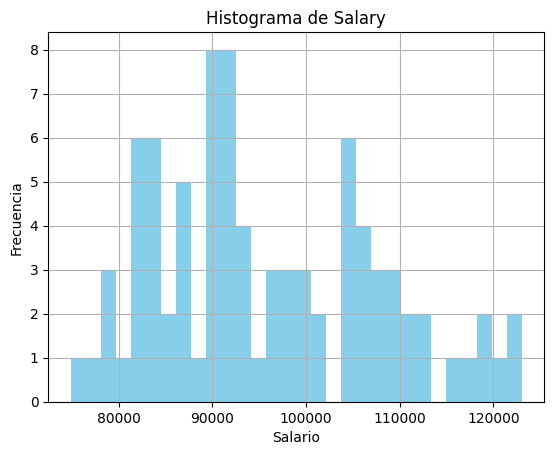

In [3]:
#histograma de salary
# Crear un objeto de figura y ejes
fig, ax = plt.subplots()

# Crear el histograma en los ejes especificados
df['salary'].hist(bins=30, ax=ax, color='skyblue')

# Añadir título y etiquetas a los ejes
ax.set_title('Histograma de Salary')
ax.set_xlabel('Salario')
ax.set_ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

Los salarios que más frecuencia tienen son los que se encuentran en medio, mientras que los salarios más altos y los más bajos tienen frecuencias bajas.

2. Crea un diagrama de dispersión de salary vs cost, considerando lo siguiente: para cada punto elegirás un color que represente la localidad en la que está el salario y el costo de la educación. Por lo tanto el diagrama de dispersión debería tener puntos en 4 colores distintos. Discute lo que observas


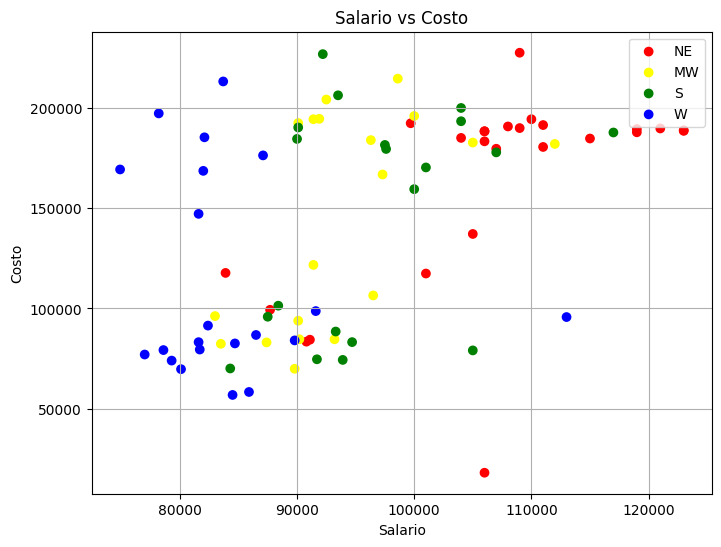

In [4]:
#diagrama de dispersion
colors = {'NE': 'red', 'W': 'blue', 'S': 'green', 'MW': 'yellow'}
df['color'] = df['location'].map(colors)

plt.figure(figsize=(8,6))
for location in df['location'].unique():
    subset = df[df['location'] == location]
    plt.scatter(subset['salary'], subset['cost'], c=subset['color'], label=location)
plt.xlabel('Salario')
plt.ylabel('Costo')
plt.title('Salario vs Costo')
plt.legend()
plt.grid(True)
plt.show()


Hay un grupo de puntos que se concentran en un bajo costo y un bajo salario; también hay un grupo parecido, pero donde hay un costo alto y salarios altos, aunque esta sección está un poco más dispersa. También hay puntos dispersos donde hay salarios bajos y costo alto, así como costo bajo y salario alto.

3. Emplea n boxplot para saber si hay diferencias en los costos según la ubicación, es decir, con boxplot deberás analizar la distribución de cost por localidad. Discute lo que observas


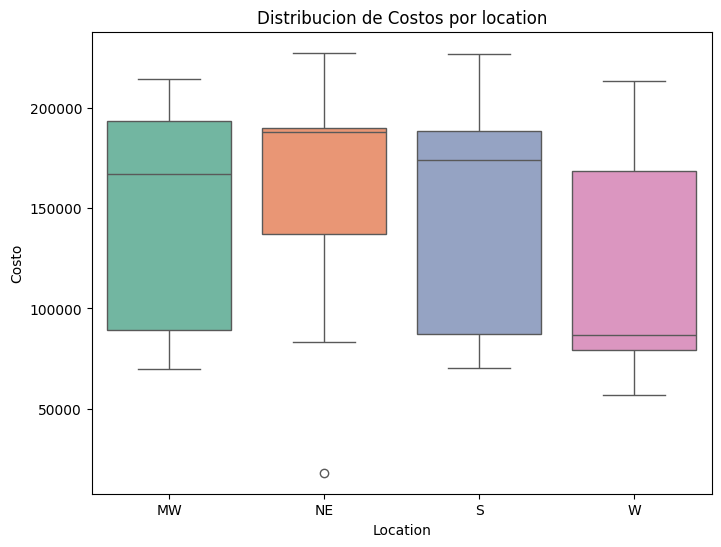

In [5]:

plt.figure(figsize=(8,6))

sns.boxplot(data=df, x = 'location', y = 'cost', hue='location', palette = 'Set2')

plt.title('Distribucion de Costos por location')
plt.suptitle('')
plt.xlabel('Location')
plt.ylabel('Costo')
plt.show()



Los costos son parecidos en las diferentes regiones, con rangos parecidos; solo NE tiene un rango notablemente más chico.

La media en MW, NE, S muestra que la mayoría de los datos están sobre la mediana, mientras que para W la media está muy por debajo de la mediana; eso quiere decir que dentro del rango se concentran los salarios hacia el cuartil menor.

# 3. Construcción del modelo de regresión

- Construye el modelo de regresión usando los datos de salario, costo y location. Recuerda que esta última debe ser en su versión codificada con one-hot encoding.
- Imprime los coeficientes e interpreta qué significan cuando se sustituyen valores en costo, y location (versión codificada). Si no recuerdas cómo se hace esta interpretación consulta los videos.


In [7]:
from sklearn.linear_model import LinearRegression
#Modelo de regresion lineal para location / salary

X = df [['location_NE', 'location_S','location_W']]

y = df['salary']

model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)

#Mostrar Resultados
print("Coeficientes regresion lineal 'Salary':")
print(f"Intercepto (MW): {model.intercept_:.2f}")
print(f"location_NE: {model.coef_[0]:.2f}")
print(f"location_S: {model.coef_[1]:.2f}")
print(f"location_W: {model.coef_[2]:.2f}")

#Modelo de regresion lineal para location / costo
y = df['cost']

model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)

#Mostrar Resultados
print("\n\nCoeficientes regresion lineneal 'Cost':")
print(f"Intercepto (MW): {model.intercept_:.2f}")
print(f"location_NE: {model.coef_[0]:.2f}")
print(f"location_S: {model.coef_[1]:.2f}")
print(f"location_W: {model.coef_[2]:.2f}")

print(y_pred)


Coeficientes regresion lineal 'Salary':
Intercepto (MW): 93694.74
location_NE: 13193.26
location_S: 2940.26
location_W: -9585.21


Coeficientes regresion lineneal 'Cost':
Intercepto (MW): 143859.47
location_NE: 19175.33
location_S: 2312.03
location_W: -30797.57
[163034.8        163034.8        163034.8        163034.8
 163034.8        143859.47368421 163034.8        146171.5
 163034.8        163034.8        163034.8        163034.8
 163034.8        163034.8        146171.5        163034.8
 146171.5        113061.9047619  163034.8        163034.8
 146171.5        163034.8        143859.47368421 163034.8
 146171.5        163034.8        143859.47368421 146171.5
 163034.8        146171.5        163034.8        146171.5
 146171.5        143859.47368421 143859.47368421 143859.47368421
 143859.47368421 143859.47368421 146171.5        143859.47368421
 146171.5        146171.5        113061.9047619  146171.5
 163034.8        146171.5        143859.47368421 143859.47368421
 146171.5        1461

## Interpretacion de coeficientes

1. Formula Regresion Lineal Salario
$$ Salary = \beta_0 + \beta_1 \cdot NE + \beta_2 \cdot S + \beta_3 \cdot W$$

$\beta0 = 93694.74 $

$\beta1 = 13193.26 $

$\beta2 = 2940.26 $

$\beta3 = -9585.21 $

$$ Salary = 93694.74 + 13193.26 \cdot NE + 2940.26 \cdot S + -9585.21 \cdot W$$


2. Formula Regresion Lineal Costo
$$ Costo = \beta_0 + \beta_1 \cdot NE + \beta_2 \cdot S + \beta_3 \cdot W$$

$\beta0 = 143859.47 $

$\beta1 = 19175.33 $

$\beta2 = 2312.03 $

$\beta3 = -30797.57 $

$$ Costo = 143859.47 + 19175.33 \cdot NE + 2312.03 \cdot S + -30797.57 \cdot W$$

# 4. Análisis de Residuos

- Construyen una visualización de predicciones (salario estimado) vs valores reales (salario real).
- Crea una gráfica de los errores residuales. Discute lo que observas

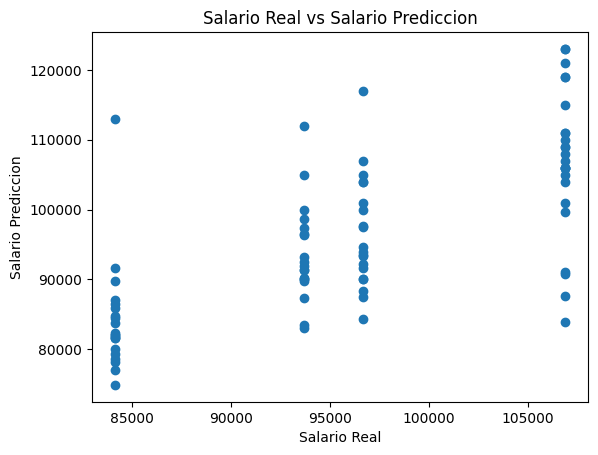

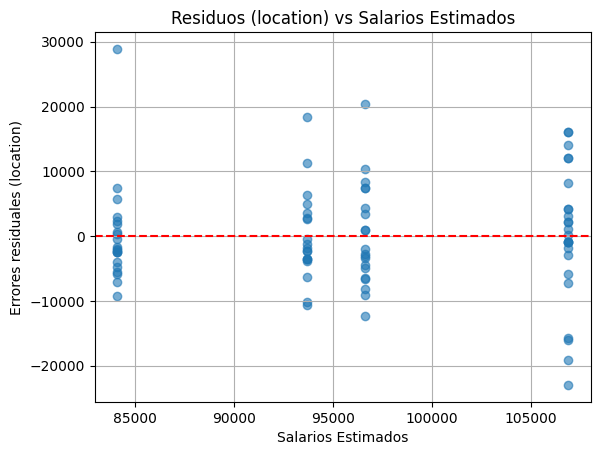

In [8]:
y = df['salary']

model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)

plt.scatter(y_pred, df['salary'] )
plt.xlabel("Salario Real")
plt.ylabel("Salario Prediccion")
plt.title("Salario Real vs Salario Prediccion")

plt.show()

residuals = y - y_pred

plt.scatter(y_pred, residuals, alpha = 0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuos (location) vs Salarios Estimados')
plt.xlabel('Salarios Estimados')
plt.ylabel('Errores residuales (location)')
plt.grid(True)
plt.show()

Creo que las líneas verticales que se generan están relacionadas con las regiones y cada punto medio es donde la predicción coincide con el valor real.

# 5. Evalúa el modelo

- Calcula el MSE del modelo construido. Recuerda que usas el propio conjunto de datos (No hablamos nada de entrenamiento y test).
- Calcula el R² Score

Discute estos resultados obtenidos.

In [9]:
from sklearn.metrics import mean_squared_error, r2_score


mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print("Error Cuadrático Medio (MSE):", mse)
print("Coeficiente de Determinación (R^2):", r2)

Error Cuadrático Medio (MSE): 69748699.63438007
Coeficiente de Determinación (R^2): 0.5046906841938358


# 6. Realiza un análisis de varianza con stastmodel

Consulta esto aquí https://www.statsmodels.org/dev/examples/notebooks/generated/variance_components.html

In [10]:
import statsmodels.formula.api as smf

model_sm = smf.ols('salary ~ C(location)', data=df,drop_cols='C(location)[T.MW]').fit()
# Calcular residuos
residuals = model_sm.resid

# También puedes obtener los valores ajustados (predichos por el modelo)
fitted_values = model_sm.fittedvalues

# Opcional: agregar al DataFrame para análisis posterior
df['residuals'] = residuals
df['fitted'] = fitted_values

# Mostrar algunos valores
print(df[['location', 'salary', 'fitted', 'residuals']].head())

  location  salary    fitted  residuals
0       NE  119000  106888.0    12112.0
1       NE  121000  106888.0    14112.0
2       NE  123000  106888.0    16112.0
3       NE  123000  106888.0    16112.0
4       NE  110000  106888.0     3112.0
